# Computer Generated Holography

<a target="_blank" href="https://colab.research.google.com/github/chromatix-team/chromatix/blob/main/docs/examples/cgh.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# If in Colab, install Chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install git+https://github.com/chromatix-team/chromatix.git

In this example, we'll demonstrate computer generated holography (CGH). In CGH, the goal is to learn to produce a target hologram by perturbing a wavefront of light at only one plane. A real CGH application would have to be much more complex to account for the mismatch between simulation and reality, and also then evaluate how well the system generates a real hologram. Here, we will be dealing only in the simulation of an ideal system for CGH to demonstrate how one can optimize parameters of a system in Chromatix. We'll base our optical setup on [1]: [DeepCGH: 3D computer-generated holography using deep learning](https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-18-26636&id=437573), though we won't be demonstrating the deep learning method discussed in that work. Instead, we'll directly optimize parameters of our optical system to reproduce a fixed target hologram.

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from jax import random
from jaxtyping import Array

from chromatix import Field
from chromatix.functional import (
    ff_lens,
    phase_change,
    plane_wave,
    transfer_propagate,
)

key = random.PRNGKey(4)

## Modeling holography

Creating a CGH model is straightforward using Chromatix. See the [Holoscope example](https://chromatix.readthedocs.io/en/latest/examples/holoscope/) for a walkthrough of putting together an Equinox `Module` that wraps up everything you want to parameterize for optimization. Here, we're making a very simple CGH model that uses a phase mask, which has trainable pixels initialized to 0.

In [2]:
class CGH(eqx.Module):
    phase: (
        Array  # This is the phase mask we want to optimize, and is not marked static!
    )
    shape: tuple[int, int] = eqx.field(static=True)
    spacing: float = eqx.field(static=True)
    z: Array = eqx.field(static=True)
    f: float = eqx.field(static=True)
    n: float = eqx.field(static=True)
    NA: float | None = eqx.field(static=True)
    pad_width: int = eqx.field(static=True)
    spectrum: float | Array = eqx.field(static=True)

    def __init__(
        self,
        shape: tuple[int, int],
        spacing: float,  # microns
        z: Array,  # microns
        f: float = 200.0e3,  # microns
        n: float = 1.0,
        NA: float | None = None,
        pad_width: int = 0,
        spectrum: float | Array = 1.035,  # microns
    ):
        self.shape = shape
        self.spacing = spacing
        self.z = z
        self.f = f
        self.n = n
        self.NA = NA
        self.pad_width = pad_width
        self.spectrum = spectrum
        self.phase = jnp.zeros(
            self.shape
        )  # Initialization of our phase mask parameter to zeros

    def __call__(self) -> Field:
        # Chromatix does the work of simulating the propagation of the plane wave into
        # the desired hologram at multiple depths. This lets us define a CGH simulation
        # in just a few lines. Note that here, we're using the functional API of Chromatix
        # with the phase mask parameter stored in this Module.
        field = plane_wave(self.shape, self.spacing, self.spectrum)
        field = phase_change(field, self.phase)
        field = ff_lens(field, self.f, self.n, self.NA)
        field = transfer_propagate(
            field, self.z, self.n, pad_width=self.pad_width, mode="same"
        )
        return field

We can initialize the model just like any `Module` in Equinox (which is just like initializing any dataclass object, because a `Module` is a PyTree). Note that we've marked every attribute that we didn't want to optimize (i.e. calculate gradients through) as a static field. This will cause a warning (in this case because of our z values), because setting fields containing arrays as static will mean they are ignored by all JAX transforms, which can be confusing. In this case, we are using it to make sure that when we compute the gradient of a loss function with respect to our model, the gradients are calculated only for the phase mask pixels. There is [another way to do this using Equinox functions to filter Modules for the parameters you want](https://docs.kidger.site/equinox/api/manipulation/#filtering-partitioning-combining), but we'll do things this way because it's easier in this case.

In [3]:
# Parameters are taken from the paper, we just use 256, 256 because of our data
shape = (256, 256)
spacing = 9.2  # microns
z = jnp.linspace(0.0, 100.0e4, num=51)  # Planes we want to simulate the hologram at
model = CGH(shape=shape, spacing=spacing, z=z)

/tmp/ipykernel_2819893/2032011435.py:5: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = CGH(shape=shape, spacing=spacing, z=z)


Let's check that the resulting output has the correct spatial extent , which we know from [[1]](https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-18-26636&id=437573) should be $\lambda f / p_s$, i.e. `spectrum * f / spacing` or `1.035 * 200e3 / 9.2 = 22500` microns or 22.5 millimeters in both height and width.

In [4]:
# We can call the model to get the field at a given z:
output_field = model()
# And we can check the spatial extent of the field:
print(output_field.extent)

[22500. 22500.]


This matches the extent of the generated pattern in the paper! We also see that now we have a `Field` which has a batch dimension size of 51, which is the number of planes we wanted to simulate:

In [5]:
# The intensity now has shape 51 x 256 x 256
print(model().intensity.shape)

(51, 256, 256)


## Creating a 3D target hologram

We'll try to make a hologram that creates three spherical spots in 3D at arbitrary locations. This is certainly a very simple target hologram, but is meant to mimic the kind of target that could be used to optogenetically stimulate neurons as described in [[1]](https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-18-26636&id=437573).

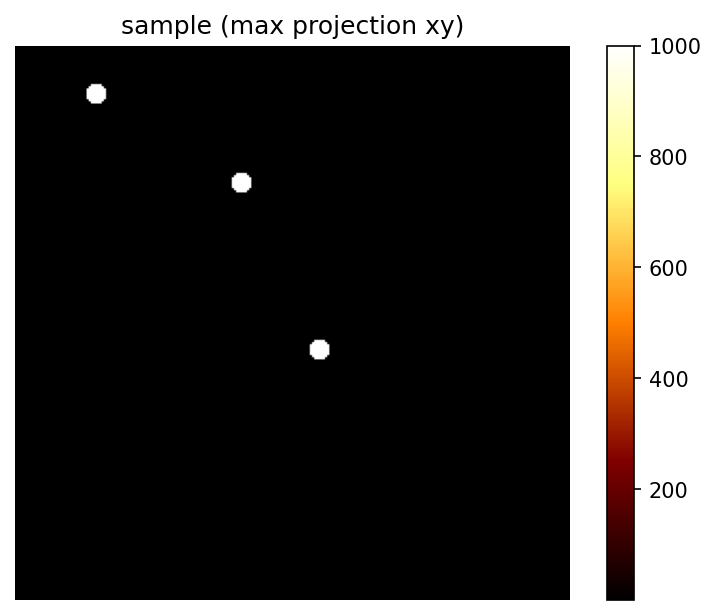

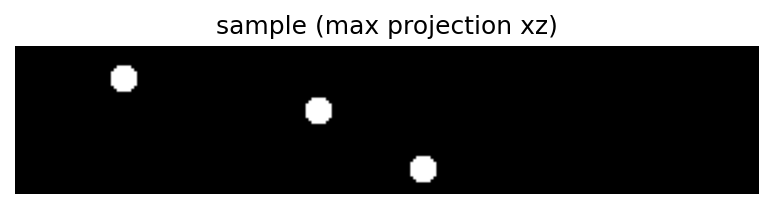

In [6]:
sample = np.zeros((51, 256, 256))
sample[30, 128, 128] = 1.0
sample[10, 51, 92] = 1.0
sample[50, 10, 25] = 1.0
diameter = 25
kernel = np.zeros((diameter, diameter, diameter))
grid = np.meshgrid(
    np.linspace(-diameter / 2, diameter / 2, num=diameter),
    np.linspace(-diameter / 2, diameter / 2, num=diameter),
    np.linspace(-diameter / 2, diameter / 2, num=diameter),
)
grid = np.sqrt(grid[0] ** 2 + grid[1] ** 2 + grid[2] ** 2)
kernel[grid < diameter / 5] = 1.0
sample = jnp.fft.ifftn(
    jnp.fft.fftn(jnp.array(sample)) * jnp.fft.fftn(jnp.array(kernel), s=sample.shape)
).real
sample = sample[..., jnp.newaxis, jnp.newaxis]
sample *= 1000.0

plt.figure(dpi=150)
plt.imshow((sample).max(0).squeeze(), cmap="afmhot")
plt.axis("off")
plt.colorbar()
plt.title("sample (max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow((sample).max(1).squeeze(), cmap="afmhot")
plt.axis("off")
plt.title("sample (max projection xz)")
plt.show()

## Optimizing the CGH system

At first, since our phase mask isn't doing anything at all, we can see that we just get a single spot that defocuses with propagation in z:

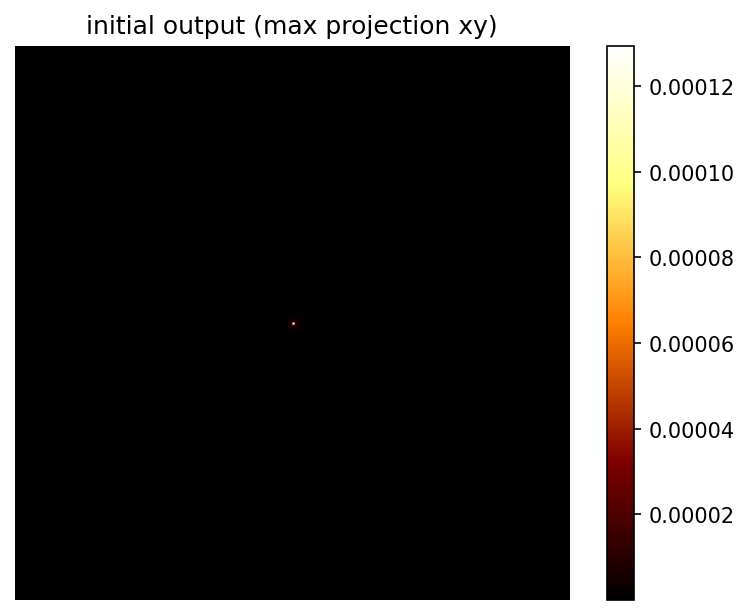

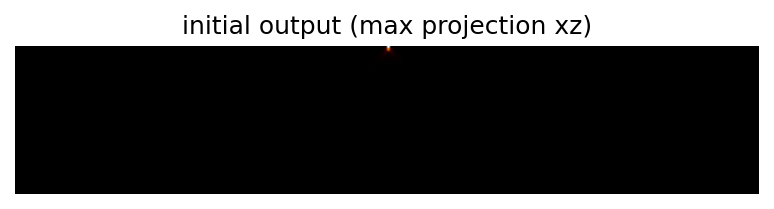

In [7]:
learned = model().intensity.squeeze()

plt.figure(dpi=150)
plt.imshow((learned).max(0).squeeze(), cmap="afmhot")
plt.axis("off")
plt.colorbar()
plt.title("initial output (max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow((learned).max(1).squeeze(), cmap="afmhot")
plt.axis("off")
plt.title("initial output (max projection xz)")
plt.show()

Let's set up a few functions to optimize our phase mask and produce the target we want. First, we'll need to compute the loss and its gradient. We'll use an inverse Pearson correlation as our loss:

In [8]:
def loss_fn(model, target):
    approx = model().intensity
    correlation = jnp.corrcoef(approx.flatten(), target.flatten())[0, 1]
    loss = 1.0 - correlation
    return loss, {"loss": loss, "correlation": correlation}


print(loss_fn(model, sample))

(Array(0.99963427, dtype=float32), {'loss': Array(0.99963427, dtype=float32), 'correlation': Array(0.00036573, dtype=float32)})


We can look at what the gradient of that loss looks like on our phase mask pixel parameters:

In [9]:
grad_fn = jax.jit(jax.grad(loss_fn, has_aux=True))
print(grad_fn(model, sample)[0].phase)

[[ 4.2289468e-08  4.9134336e-08 -9.9928625e-09 ...  4.8268447e-08
   4.2160242e-08  3.7527276e-08]
 [ 1.3656202e-08 -4.6923439e-08 -3.4971126e-08 ... -5.6192486e-09
   1.7105325e-09  1.5414294e-09]
 [-4.4434572e-08  1.1001510e-08  5.1771391e-08 ... -4.0481467e-08
  -3.9369528e-08 -4.2009525e-08]
 ...
 [-4.5299572e-08 -3.2301603e-08  3.1834137e-08 ... -5.0249678e-08
  -4.8757705e-08 -5.3358875e-08]
 [-4.3493561e-08  1.4321653e-08  5.3390881e-08 ... -3.6701117e-08
  -4.6203816e-08 -4.3214492e-08]
 [-7.2456534e-09  4.2700123e-08  3.2716827e-08 ...  2.7251701e-09
   9.6262220e-10 -4.1717789e-09]]


These gradients seem reasonable enough. Next, we'll need an optimizer, for which we'll reach for Optax. Optax contains most of the typical optimizers used in deep learning. We'll use Adam for now.

In [10]:
optimizer = optax.adam(learning_rate=1e-1)
opt_state = optimizer.init(model)

Now we can write the training loop. Since we want to compile as much code as we can, we'll try to compile one entire step of training --- including the forward simulation, computing the loss and the gradient with respect to the phase mask pixel parameters, and finally using the gradient with Adam to update the parameters. Because our parameters are stored in a Module where we've marked everything we didn't want to optimize as static, we can pass the model directly to this update function and get back an updated model with updated phase mask pixels. This can all happen in relatively few lines:

In [11]:
@jax.jit
def update(model, opt_state, target):
    grads, metrics = jax.grad(loss_fn, has_aux=True)(model, target)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, opt_state, metrics

In [12]:
%%time
max_iterations = 1000
history = {
    "loss": np.zeros((max_iterations)),
    "correlation": np.zeros((max_iterations)),
}
for iteration in range(max_iterations):
    model, opt_state, metrics = update(model, opt_state, sample)
    for m in metrics:
        history[m][iteration] = metrics[m]
    if iteration % 200 == 0:
        print(iteration, metrics)

0 {'correlation': Array(0.00036573, dtype=float32), 'loss': Array(0.99963427, dtype=float32)}
200 {'correlation': Array(0.7024737, dtype=float32), 'loss': Array(0.2975263, dtype=float32)}
400 {'correlation': Array(0.7094718, dtype=float32), 'loss': Array(0.29052818, dtype=float32)}
600 {'correlation': Array(0.7131289, dtype=float32), 'loss': Array(0.28687108, dtype=float32)}
800 {'correlation': Array(0.71380574, dtype=float32), 'loss': Array(0.28619426, dtype=float32)}
CPU times: user 23.4 s, sys: 393 ms, total: 23.8 s
Wall time: 41.1 s


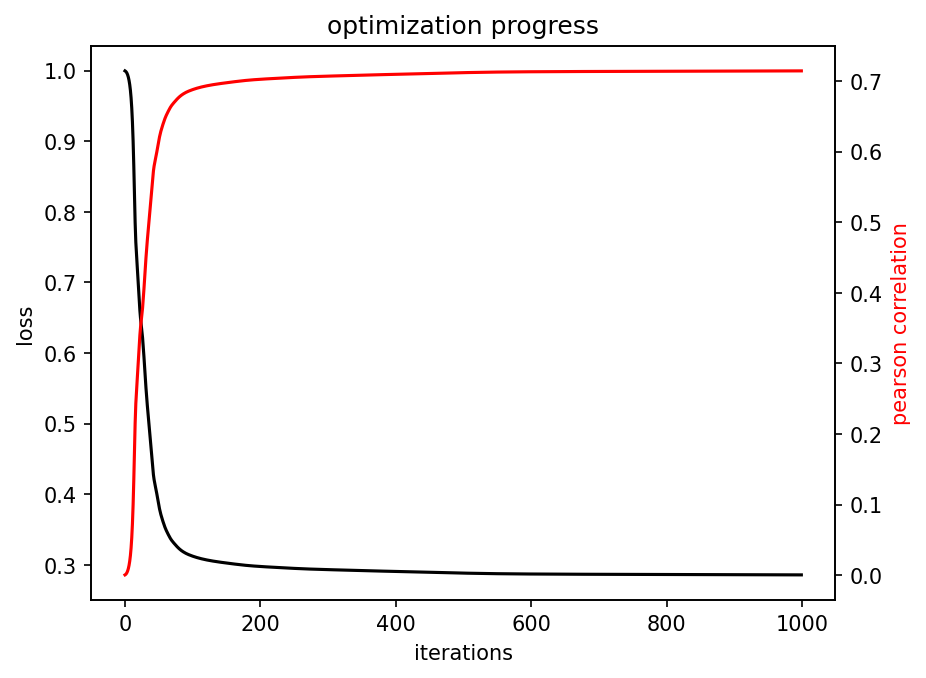

In [13]:
fig, ax1 = plt.subplots(dpi=150)

ax1.plot(np.array(history["loss"]), color="black")
ax1.set_ylabel("loss")
ax1.set_xlabel("iterations")

ax2 = ax1.twinx()
ax2.plot(np.array(history["correlation"]), color="red")
ax2.set_ylabel("pearson correlation", color="red")
plt.title("optimization progress")
plt.show()

## Evaluation

So finally we can see how we did! We'll simulate the forward pass of our optical system with our learned phase mask pixels to see what we expect the hologram to look like after training:

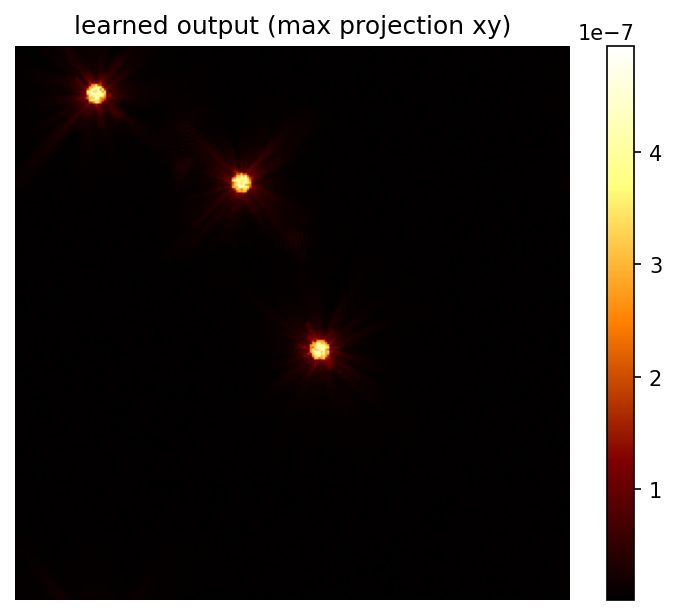

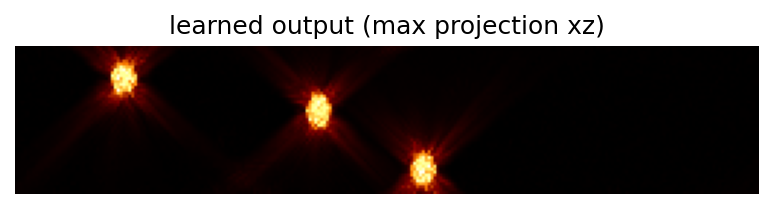

In [14]:
learned = model().intensity.squeeze()

plt.figure(dpi=150)
plt.imshow((learned).max(0).squeeze(), cmap="afmhot")
plt.axis("off")
plt.colorbar()
plt.title("learned output (max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow((learned).max(1).squeeze(), cmap="afmhot")
plt.axis("off")
plt.title("learned output (max projection xz)")
plt.show()

We can see our basic 3D target hologram! We could still improve this in many ways --- we'll leave these as an exercise to the reader.